In [75]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('bon', 4, 2)

In [7]:
from loren_frank_data_processing import get_interpolated_position_dataframe
from src.parameters import ANIMALS, SAMPLING_FREQUENCY

In [6]:
from spectral_connectivity import Multitaper, Connectivity
from loren_frank_data_processing import get_LFPs, reshape_to_segments, make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
        epoch_key, drop_level=False)

is_brain_areas = tetrode_info.area.isin(['CA1'])
is_brain_areas = is_brain_areas & tetrode_info.validripple
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()

LFPs = get_LFPs(tetrode_keys, ANIMALS)

tetrode_info[is_brain_areas].loc[:, ['area', 'depth', 'descrip']]

area    depth descrip
animal day epoch tetrode_number                      
bon    4   2     4               CA1  [[107]]     NaN
                 5               CA1  [[105]]     NaN
                 11              CA1   [[96]]     NaN
                 12              CA1  [[136]]     NaN
                 13              CA1   [[94]]     NaN
                 14              CA1   [[96]]     NaN
                 17              CA1  [[108]]     NaN
                 29              CA1  [[118]]     NaN

In [49]:
from ripple_detection import Kay_ripple_detector

speed = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, max_distance_from_well=3).speed
not_null = np.all(pd.notnull(LFPs), axis=1) & pd.notnull(speed)

ripple_times = Kay_ripple_detector(
        LFPs.index[not_null], LFPs.values[not_null], speed.values[not_null],
        SAMPLING_FREQUENCY, minimum_duration=pd.Timedelta(milliseconds=15),
        zscore_threshold=3)

In [50]:
ripple_times.head()

start_time        end_time
ripple_number                                
1             00:41:20.068133 00:41:20.124800
2             00:41:24.089467 00:41:24.206800
3             00:41:25.005467 00:41:25.096133
4             00:41:26.718800 00:41:26.786133
5             00:41:29.118800 00:41:29.178133

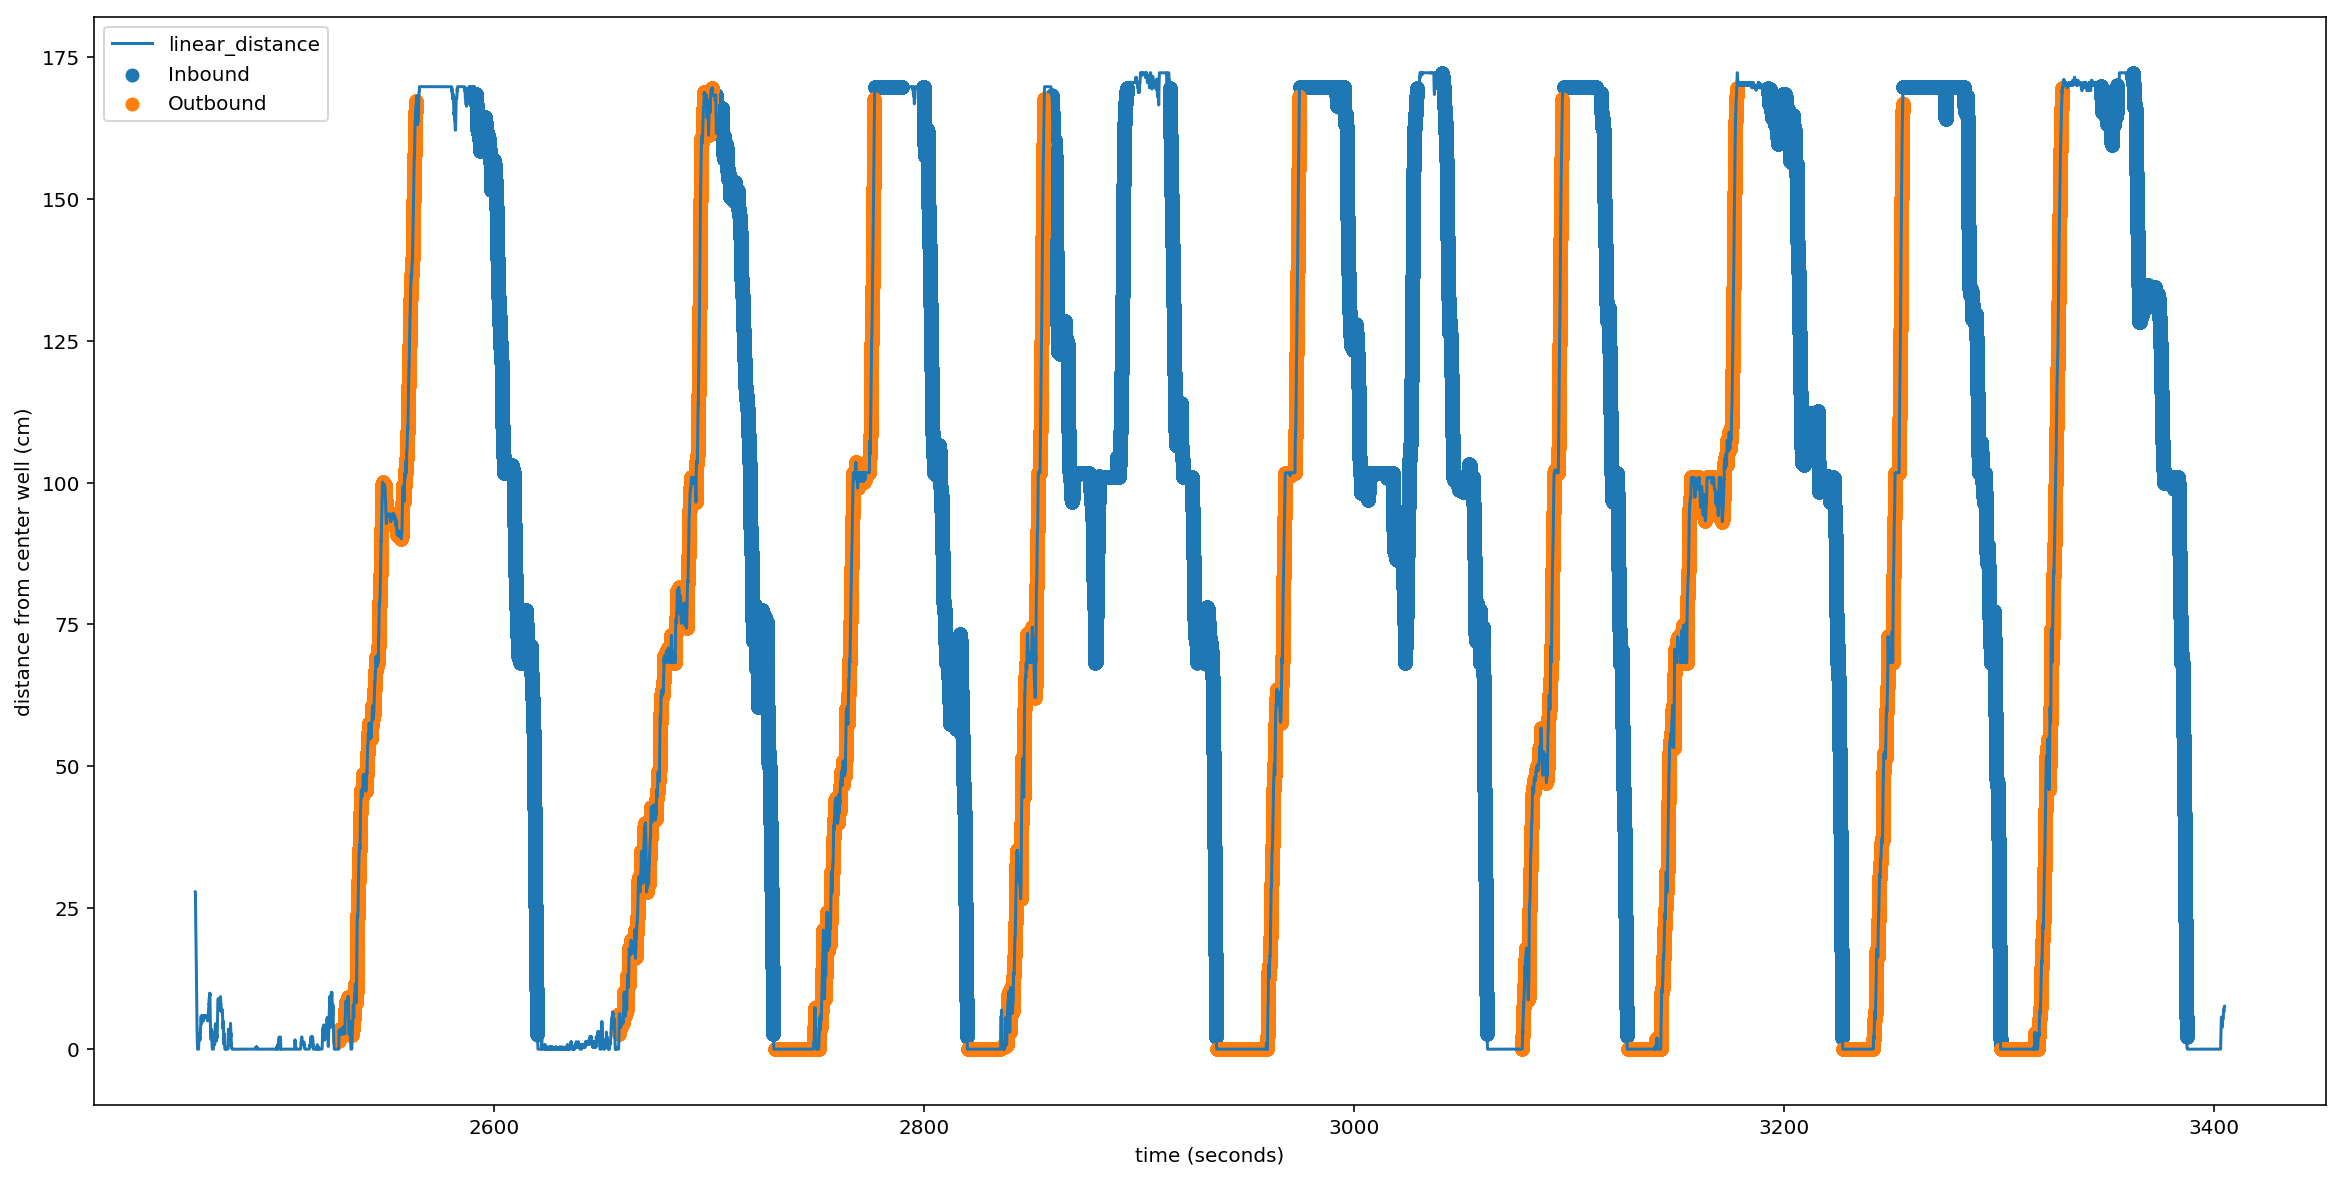

In [51]:
position_info = get_interpolated_position_dataframe(
    epoch_key, ANIMALS, max_distance_from_well=3)

plt.figure(figsize=(20, 10))
plt.plot(position_info.index.total_seconds(), position_info.linear_distance)

for label, df in position_info.groupby('task'):
    plt.scatter(df.index.total_seconds(), df.linear_distance, label=label)

plt.xlabel('time (seconds)')
plt.ylabel('distance from center well (cm)')
plt.legend();

In [55]:
window_offset = (-0.5, 0.5)

ripple_locked_LFPs = reshape_to_segments(
    LFPs, ripple_times,
    window_offset=window_offset, sampling_frequency=SAMPLING_FREQUENCY)
ripple_locked_LFPs.columns = tetrode_info[is_brain_areas].tetrode_id
ripple_locked_LFPs = (ripple_locked_LFPs.to_xarray()
                      .to_array(dim='signals').transpose('time', 'ripple_number', 'signals'))
m = Multitaper(
    ripple_locked_LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=window_offset[0])
c = Connectivity.from_multitaper(m)
ripple_locked_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=-0.5, n_tapers=5)


In [59]:
m = Multitaper(
    LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.100,
    time_halfbandwidth_product=3, start_time=LFPs.index.total_seconds()[0])
c = Connectivity.from_multitaper(m)
power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.050, frequency=c.frequencies), name='power')

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=2460.9888, n_tapers=5)


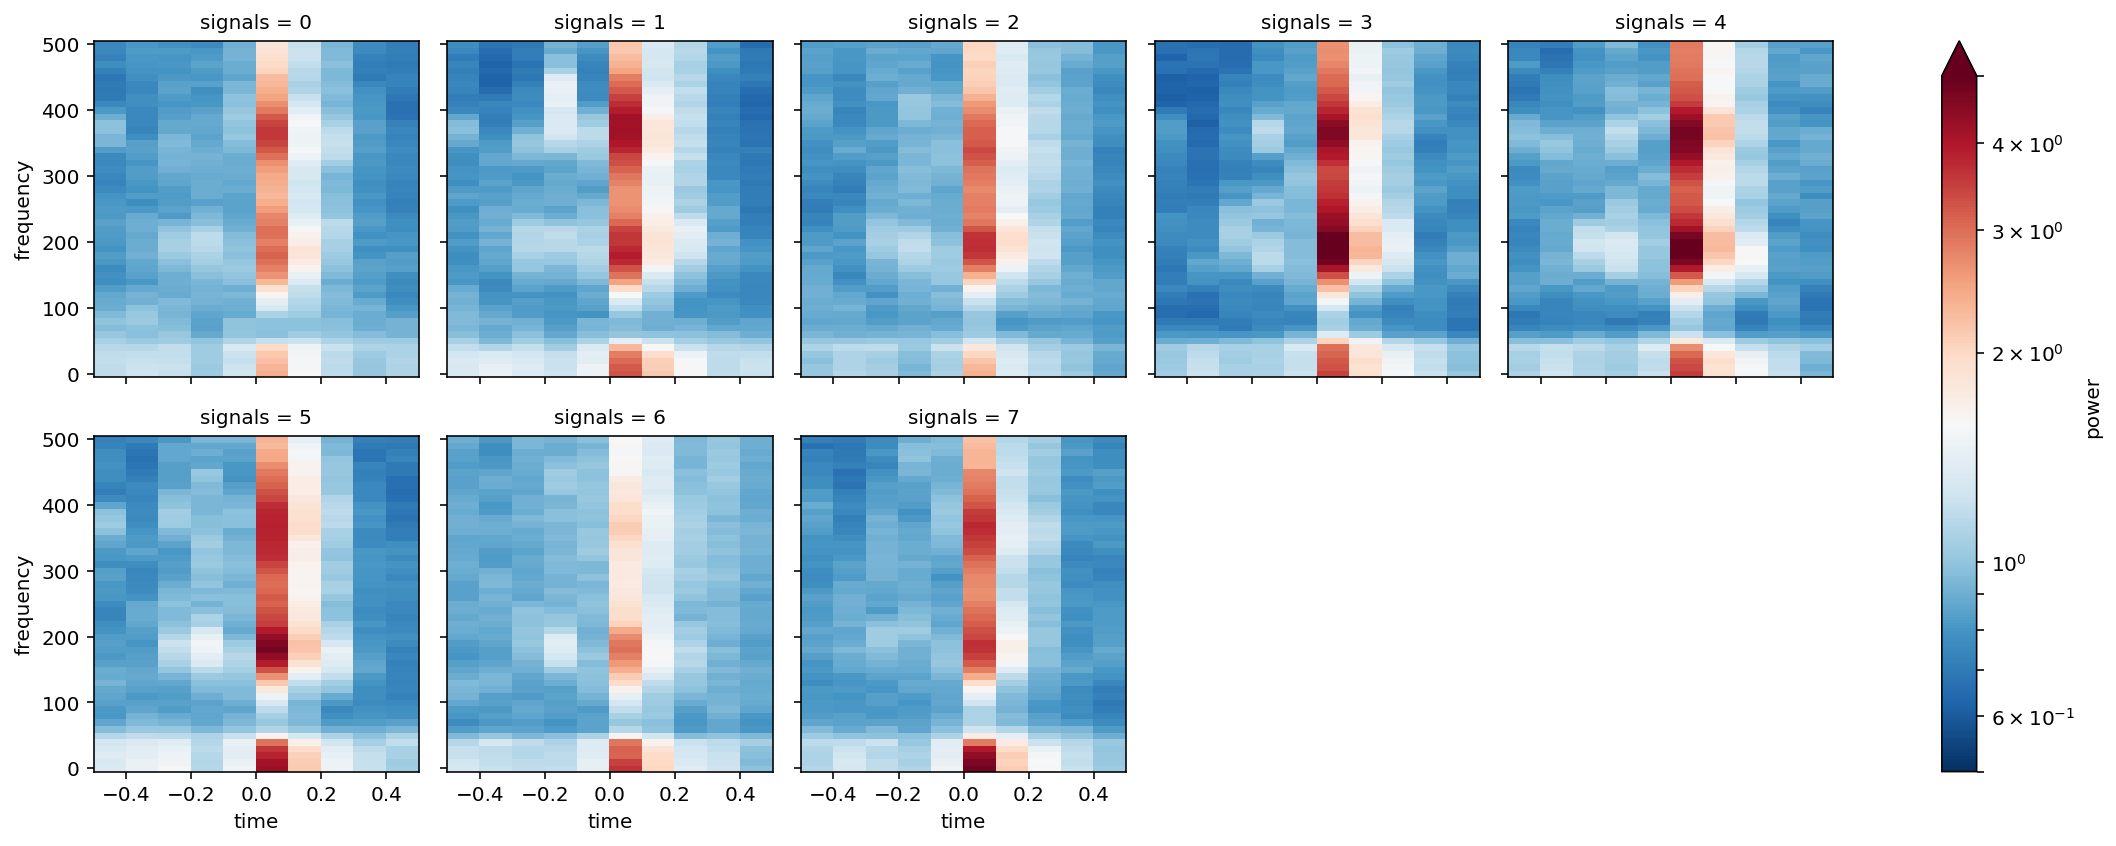

In [60]:
from matplotlib.colors import LogNorm

vmin, vmax = 0.5, 5

(ripple_locked_power / power.mean('time')).sel(frequency=slice(0, 500)).plot(
    x='time', y='frequency', col='signals', col_wrap=5, center=0,
    norm=LogNorm(vmin=vmin, vmax=vmax), vmin=vmin, vmax=vmax,
    cmap='RdBu_r');

In [61]:
ripple_duration = ripple_times.end_time.dt.total_seconds() - ripple_times.start_time.dt.total_seconds()

In [62]:
from ripple_detection.core import filter_ripple_band

ripple_filtered_LFPs = pd.DataFrame(
    np.stack([filter_ripple_band(lfp, SAMPLING_FREQUENCY) for lfp in LFPs.values.T], axis=1),
    index=LFPs.index, columns=tetrode_keys)

ripple_locked_filtered_LFPs = reshape_to_segments(
    ripple_filtered_LFPs, ripple_times, window_offset=window_offset,
    sampling_frequency=SAMPLING_FREQUENCY)

In [65]:
m = Multitaper(LFPs.values, SAMPLING_FREQUENCY, time_window_duration=0.020,
                                     time_window_step=0.004,
               time_halfbandwidth_product=1, start_time=LFPs.index.total_seconds()[0])
c = Connectivity.from_multitaper(m)
ripple_power = xr.DataArray(c.power(), dims=('time', 'frequency', 'signals'),
                            coords=dict(time=pd.TimedeltaIndex(c.time, unit='s'), frequency=c.frequencies), name='power')
ripple_power = ripple_power.sel(frequency=200).reindex(LFPs.index)
ripple_power /= ripple_power.mean('time')
ripple_locked_power = reshape_to_segments(
    ripple_power.drop('frequency').to_dataframe().unstack(), ripple_times, window_offset,
    sampling_frequency=SAMPLING_FREQUENCY)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.004,
           detrend_type='constant', start_time=2460.9888, n_tapers=1)


In [67]:
from ipywidgets import interact

ripple_time = ripple_locked_LFPs.get_index('time').total_seconds().values

def plot_lfp(ripple_number=1):
    n_LFPs = LFPs.shape[1]
    fig, axes = plt.subplots(n_LFPs, 3, figsize=(20, 10), sharex=True)
    for ax, lfp in zip(
            axes[:, 0], ripple_locked_LFPs.sel(ripple_number=1).values.T):
        ax.plot(ripple_time, lfp)
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    for ax, lfp in zip(
            axes[:, 1], ripple_locked_filtered_LFPs.loc[ripple_number].values.T):
        ax.plot(ripple_time, lfp, color='orange')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(0, color='black', linestyle='--')

    power_time = ripple_locked_power.loc[ripple_number].index.total_seconds().values
    for ax, p in zip(axes[:, 2], ripple_locked_power.loc[ripple_number].values.T):
        ax.plot(power_time, p, color='purple')
        ax.axvspan(0, ripple_duration.loc[ripple_number], alpha=0.2)
        ax.axhline(1, color='black', linestyle='--')

    axes[0, 0].set_title('LFP')
    axes[0, 1].set_title('Bandpass Filtered LFP (150 - 250 Hz)')
    axes[0, 2].set_title('Ripple Power Change');

n_ripples = len(ripple_times)
interact(plot_lfp, ripple_number=(1, n_ripples), continuous_update=False);

interactive(children=(IntSlider(value=1, description='ripple_number', max=157, min=1), Output()), _dom_classes=('widget-interact',))

In [68]:
from loren_frank_data_processing import make_neuron_dataframe, get_spike_indicator_dataframe

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False).loc[:, ['area', 'numspikes']].dropna()
neuron_info = neuron_info.loc[neuron_info.numspikes > 0]

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve, gaussian

from loren_frank_data_processing import (get_multiunit_indicator_dataframe,
                                         get_spike_indicator_dataframe,
                                         reshape_to_segments)


def plot_perievent_raster(neuron_or_tetrode_key, animals, events, tetrode_info,
                          window_offset=(-0.5, 0.5),
                          sampling_frequency=1500, ax=None,
                          **scatter_kwargs):
    '''Plot spike raster relative to an event.

    Parameters
    ----------
    neuron_or_tetrode_key : tuple
    animals : dict of namedtuples
    events : pandas DataFrame, shape (n_events, 2)
    tetrode_info : pandas DataFrame, shape (n_tetrodes, ...)
    window_offset : tuple, optional
    sampling_frequency : tuple, optional
    ax : matplotlib axes, optional
    scatter_kwargs : dict

    Returns
    -------
    ax : matplotlib axes

    '''
    if ax is None:
        ax = plt.gca()
    try:
        spikes = get_spike_indicator_dataframe(neuron_or_tetrode_key, animals)
    except ValueError:
        spikes = ((get_multiunit_indicator_dataframe(
            neuron_or_tetrode_key, animals) > 0).sum(axis=1) > 0) * 1.0
    event_locked_spikes = reshape_to_segments(
        spikes, events, window_offset=window_offset,
        sampling_frequency=sampling_frequency).unstack(level=0).fillna(0)
    time = event_locked_spikes.index.total_seconds()
    spike_index, event_number = np.nonzero(event_locked_spikes.values)

    ax.scatter(time[spike_index], event_number, **scatter_kwargs)
    ax.axvline(0.0, color='black')
    ax.set_title(
        tetrode_info.loc[neuron_or_tetrode_key[:4]].area.upper() + ' - ' +
        str(neuron_or_tetrode_key))
    ax.set_ylabel(events.index.name)
    ax.set_xlabel('time (seconds)')
    ax.set_ylim((0, events.index.max() + 1))
    ax.set_xlim(window_offset)

    ax2 = ax.twinx()
    kde = kernel_density_estimate(
        event_locked_spikes, sampling_frequency, sigma=0.025)
    m = ax2.plot(time, kde[:, 1], color='blue', alpha=0.8)
    ax2.fill_between(time, kde[:, 0], kde[:, 2],
                     color=m[0].get_color(), alpha=0.2)
    ax2.set_ylabel('Firing Rate (spikes / s)')

    return ax


def kernel_density_estimate(
        is_spike, sampling_frequency, sigma=0.025):
    '''The gaussian-smoothed kernel density estimate of firing rate over
    trials.

    Parameters
    ----------
    is_spike : ndarray, shape (n_time, n_trials)
    sampling_frequency : float
    bandwidth : float

    Returns
    -------
    firing_rate : ndarray, shape (n_time,)

    '''
    bandwidth = sigma * sampling_frequency
    n_window_samples = int(bandwidth * 8)
    kernel = gaussian(n_window_samples, bandwidth)[:, np.newaxis]
    density_estimate = convolve(
        is_spike, kernel, mode='same') / kernel.sum()
    n_events = density_estimate.shape[1]
    firing_rate = np.nanmean(density_estimate, axis=1,
                             keepdims=True) * sampling_frequency
    firing_rate_std = (np.nanstd(density_estimate, axis=1, keepdims=True) *
                       sampling_frequency / np.sqrt(n_events))
    ci = np.array([-1.96, 0, 1.96])
    return firing_rate + firing_rate_std * ci


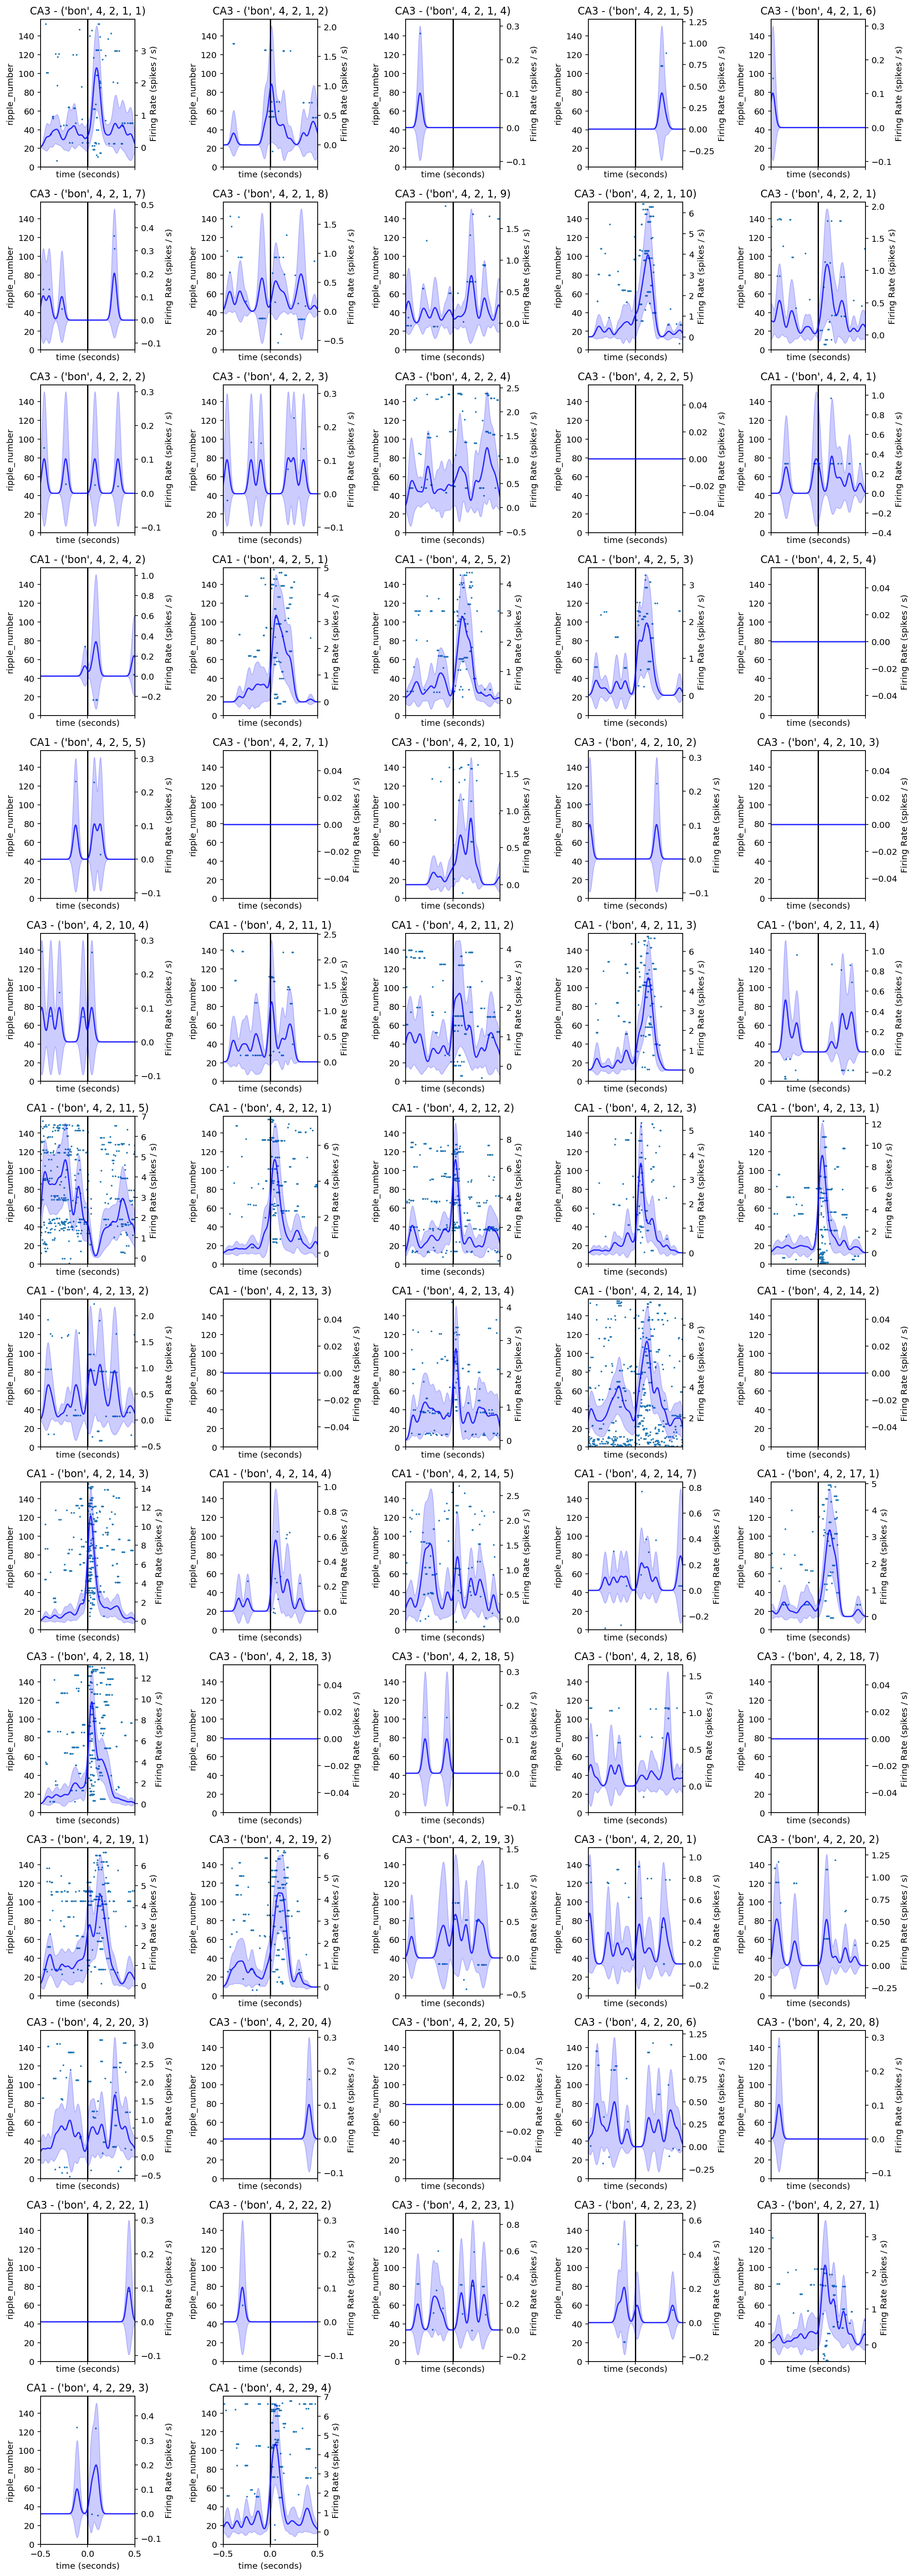

In [71]:
neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          tetrode_info, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

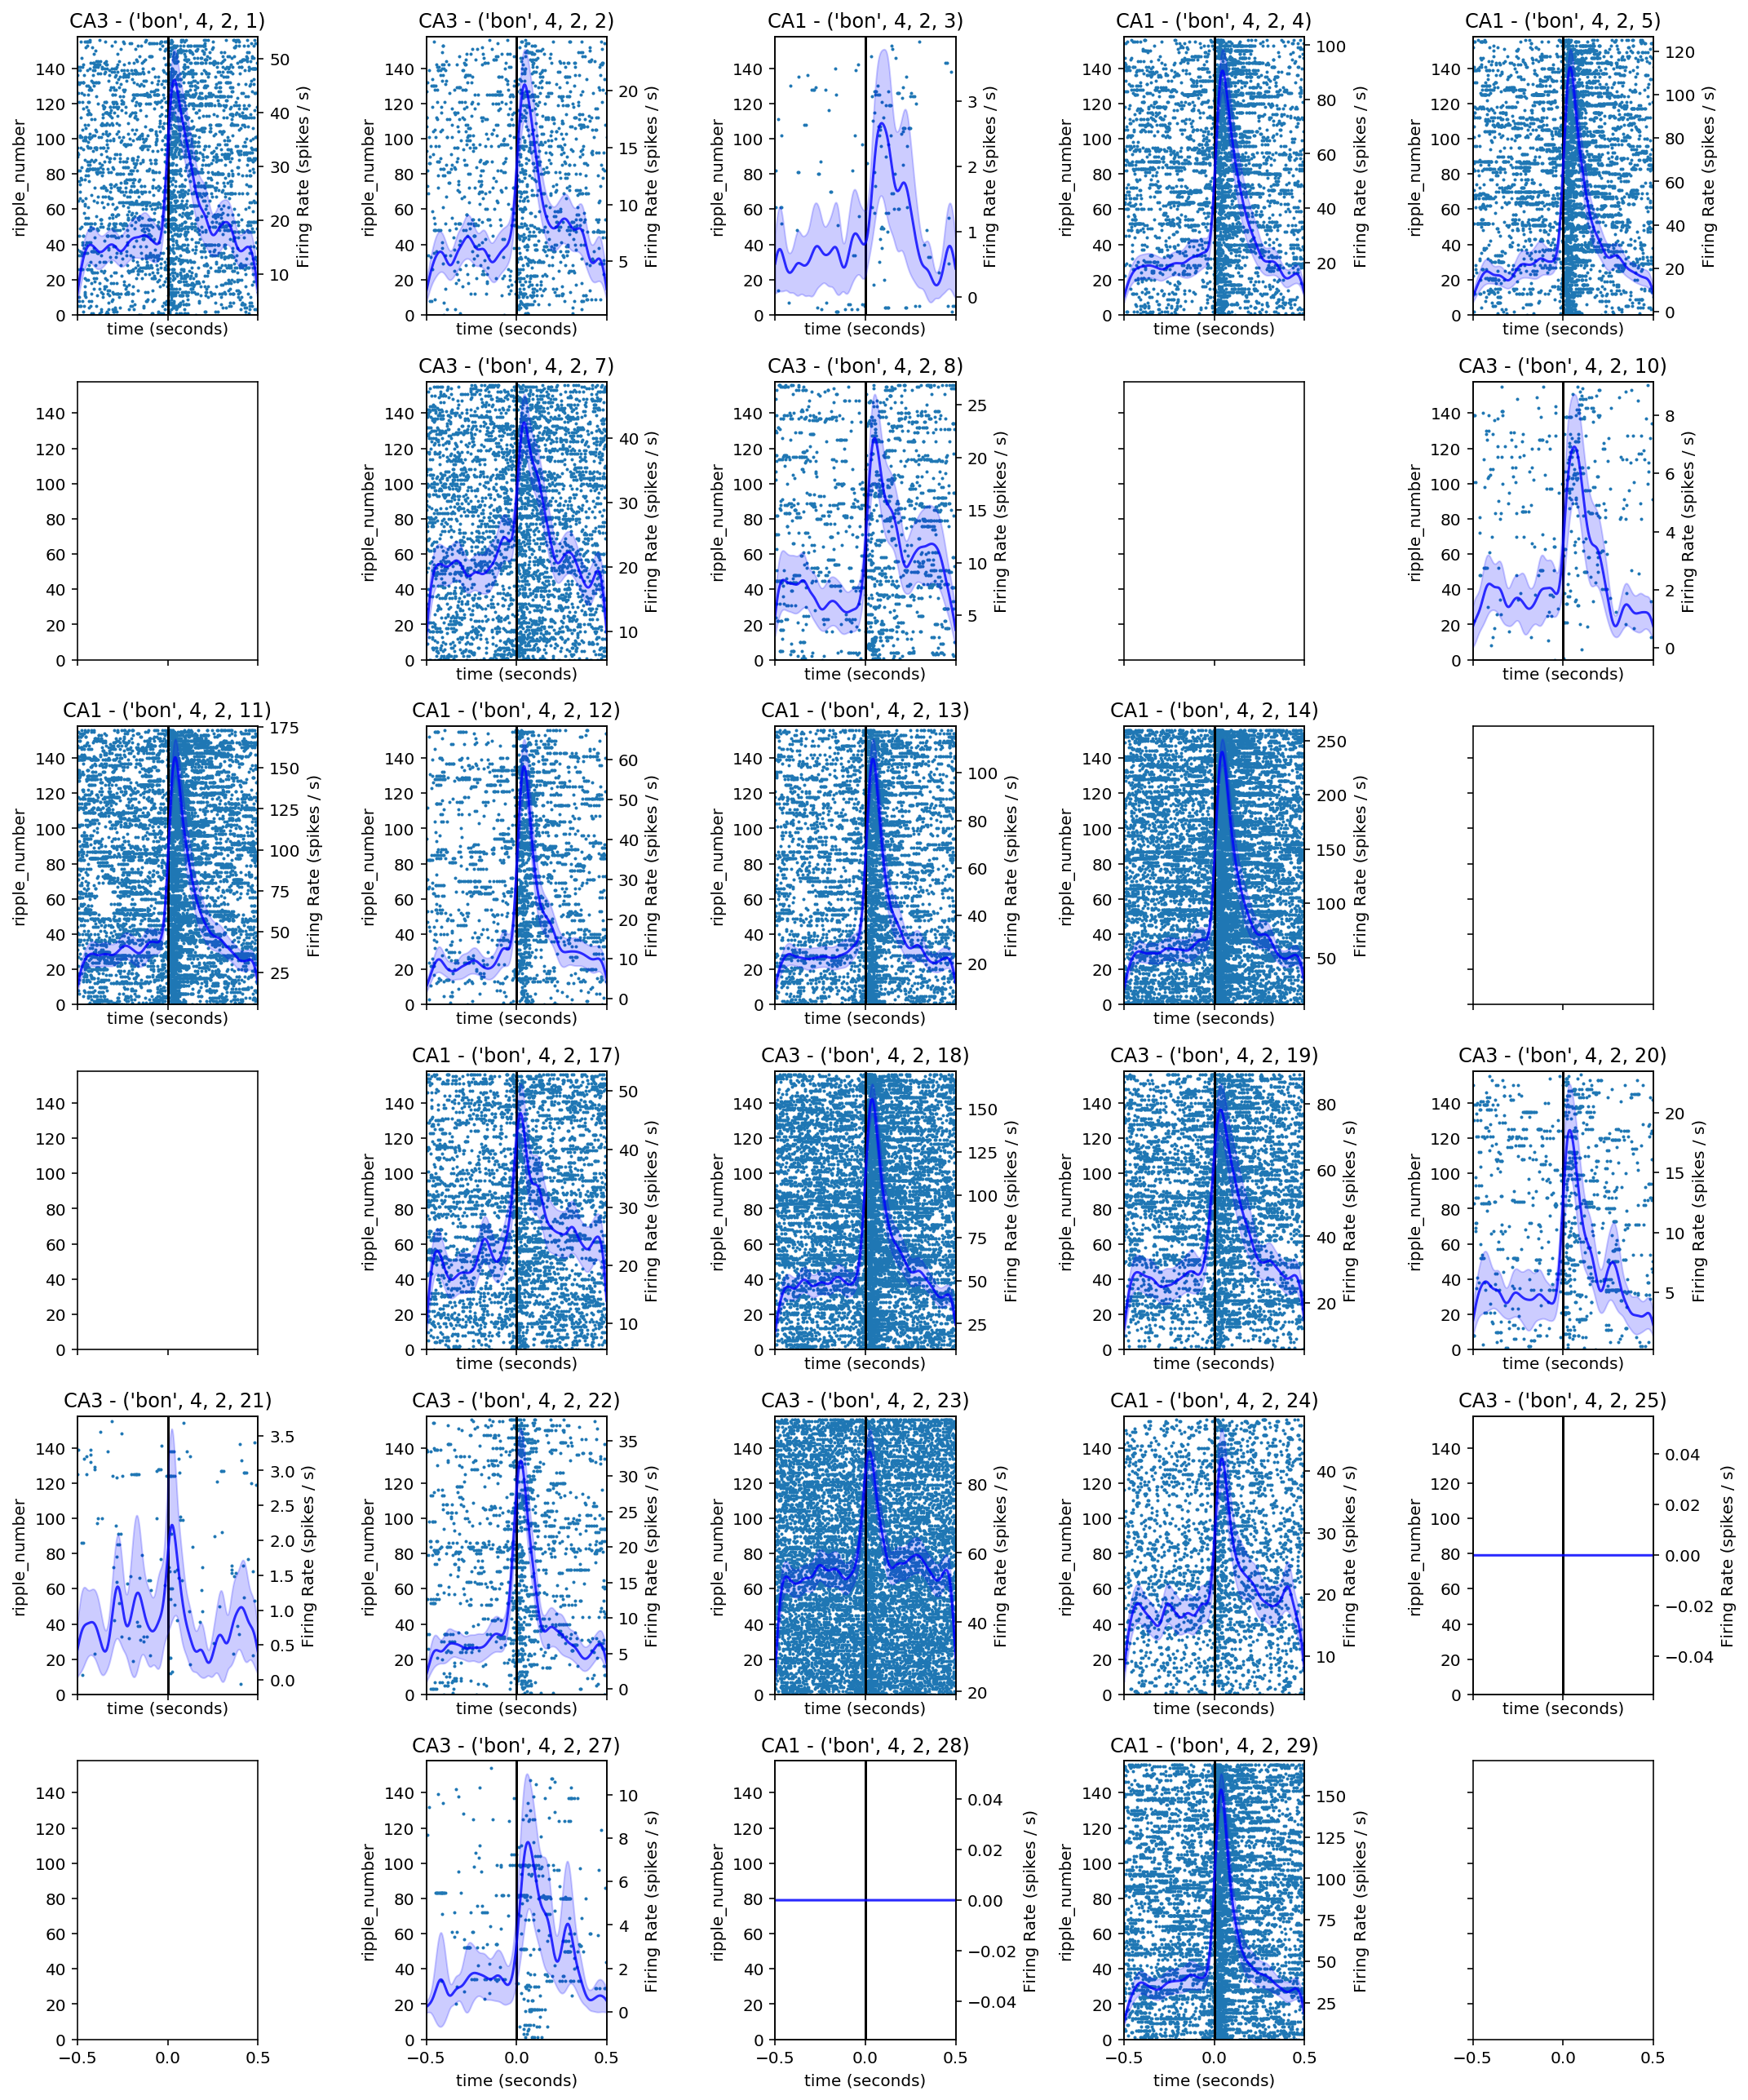

In [76]:
tetrode_keys = tetrode_info.index
n_tetrodes = len(tetrode_keys)

col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), tetrode_keys):
    try:
        plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                              tetrode_info, window_offset=(-0.5, 0.5),
                              ax=ax, s=1)
    except TypeError:
        pass
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')

plt.tight_layout()

In [191]:
from loren_frank_data_processing import (get_interpolated_position_dataframe,
                                         get_LFP_dataframe,
                                         get_multiunit_indicator_dataframe,
                                         get_spike_indicator_dataframe,
                                         make_neuron_dataframe,
                                         make_tetrode_dataframe,
                                         reshape_to_segments, save_xarray)
from replay_classification import ClusterlessDecoder, SortedSpikeDecoder

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
brain_areas_tetrodes = tetrode_info[
    tetrode_info.area.isin(['CA1']) &
    tetrode_info.validripple]

mark_names = get_multiunit_indicator_dataframe(
    brain_areas_tetrodes.index[0], ANIMALS).columns.tolist()
mark_names = [mark_name for mark_name in mark_names
              if mark_name not in ['x_position', 'y_position']]
mark_names = mark_names[:4]
marks = [(get_multiunit_indicator_dataframe(tetrode_key, ANIMALS)
      .loc[:, mark_names])
     for tetrode_key in brain_areas_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
     if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
         .shape[0]) != 0]

train_position_info = position_info.query('speed > 4')

training_marks = np.stack([
    tetrode_marks.loc[train_position_info.index, mark_names]
    for tetrode_marks in marks], axis=0)

n_position_bins = 61
place_std_deviation = 20
mark_std_deviation = 20

decoder = ClusterlessDecoder(
        train_position_info.linear_distance.values,
        train_position_info.task.values,
        training_marks,
        n_position_bins=n_position_bins,
        place_std_deviation=place_std_deviation,
        mark_std_deviation=mark_std_deviation,
        replay_speedup_factor=16,
    ).fit()

display(brain_areas_tetrodes)

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


area    depth descrip hemisphere  maxcell  \
animal day epoch tetrode_number                                             
bon    4   2     4               CA1  [[107]]     NaN      right      NaN   
                 5               CA1  [[105]]     NaN      right      NaN   
                 11              CA1   [[96]]     NaN      right      NaN   
                 12              CA1  [[136]]     NaN       left      NaN   
                 13              CA1   [[94]]     NaN       left      NaN   
                 14              CA1   [[96]]     NaN       left      1.0   
                 17              CA1  [[108]]     NaN       left      NaN   
                 29              CA1  [[118]]     NaN      right      NaN   

                                 nearCA2  numcells  representative subarea  \
animal day epoch tetrode_number                                              
bon    4   2     4                   0.0       2.0             NaN    CA1c   
                 5                   0.0       5.0             NaN    CA1c   
                 11                  0.0       6.0             NaN    CA1c   
                 12                  0.0       4.0             NaN    CA1c   
                 13                  0.0       4.0             NaN    CA1c   
                 14                  0.0       8.0             1.0    CA1c   
                 17                  0.0       2.0             NaN    CA1c   
                 29                  0.0       4.0             NaN    CA1c   

                                    tetrode_id  validripple  
animal day epoch tetrode_number                              
bon    4   2     4               bon_04_02_004          1.0  
                 5               bon_04_02_005          1.0  
                 11              bon_04_02_011          1.0  
                 12              bon_04_02_012          1.0  
                 13              bon_04_02_013          1.0  
                 14              bon_04_02_014          1.0  
                 17              bon_04_02_017          1.0  
                 29              bon_04_02_029          1.0

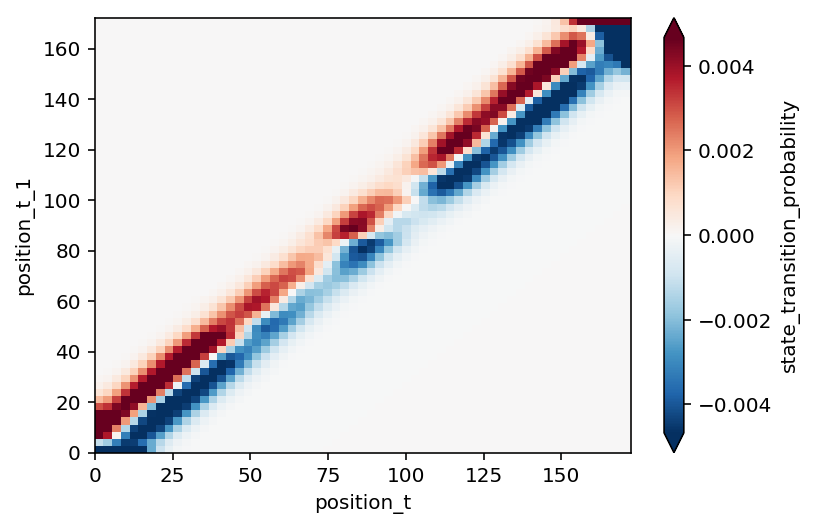

In [78]:
(decoder.state_transition_matrix.sel(state='Inbound-Forward') -
 decoder.state_transition_matrix.sel(state='Outbound-Forward')).plot(x='position_t', y='position_t_1', robust=True)

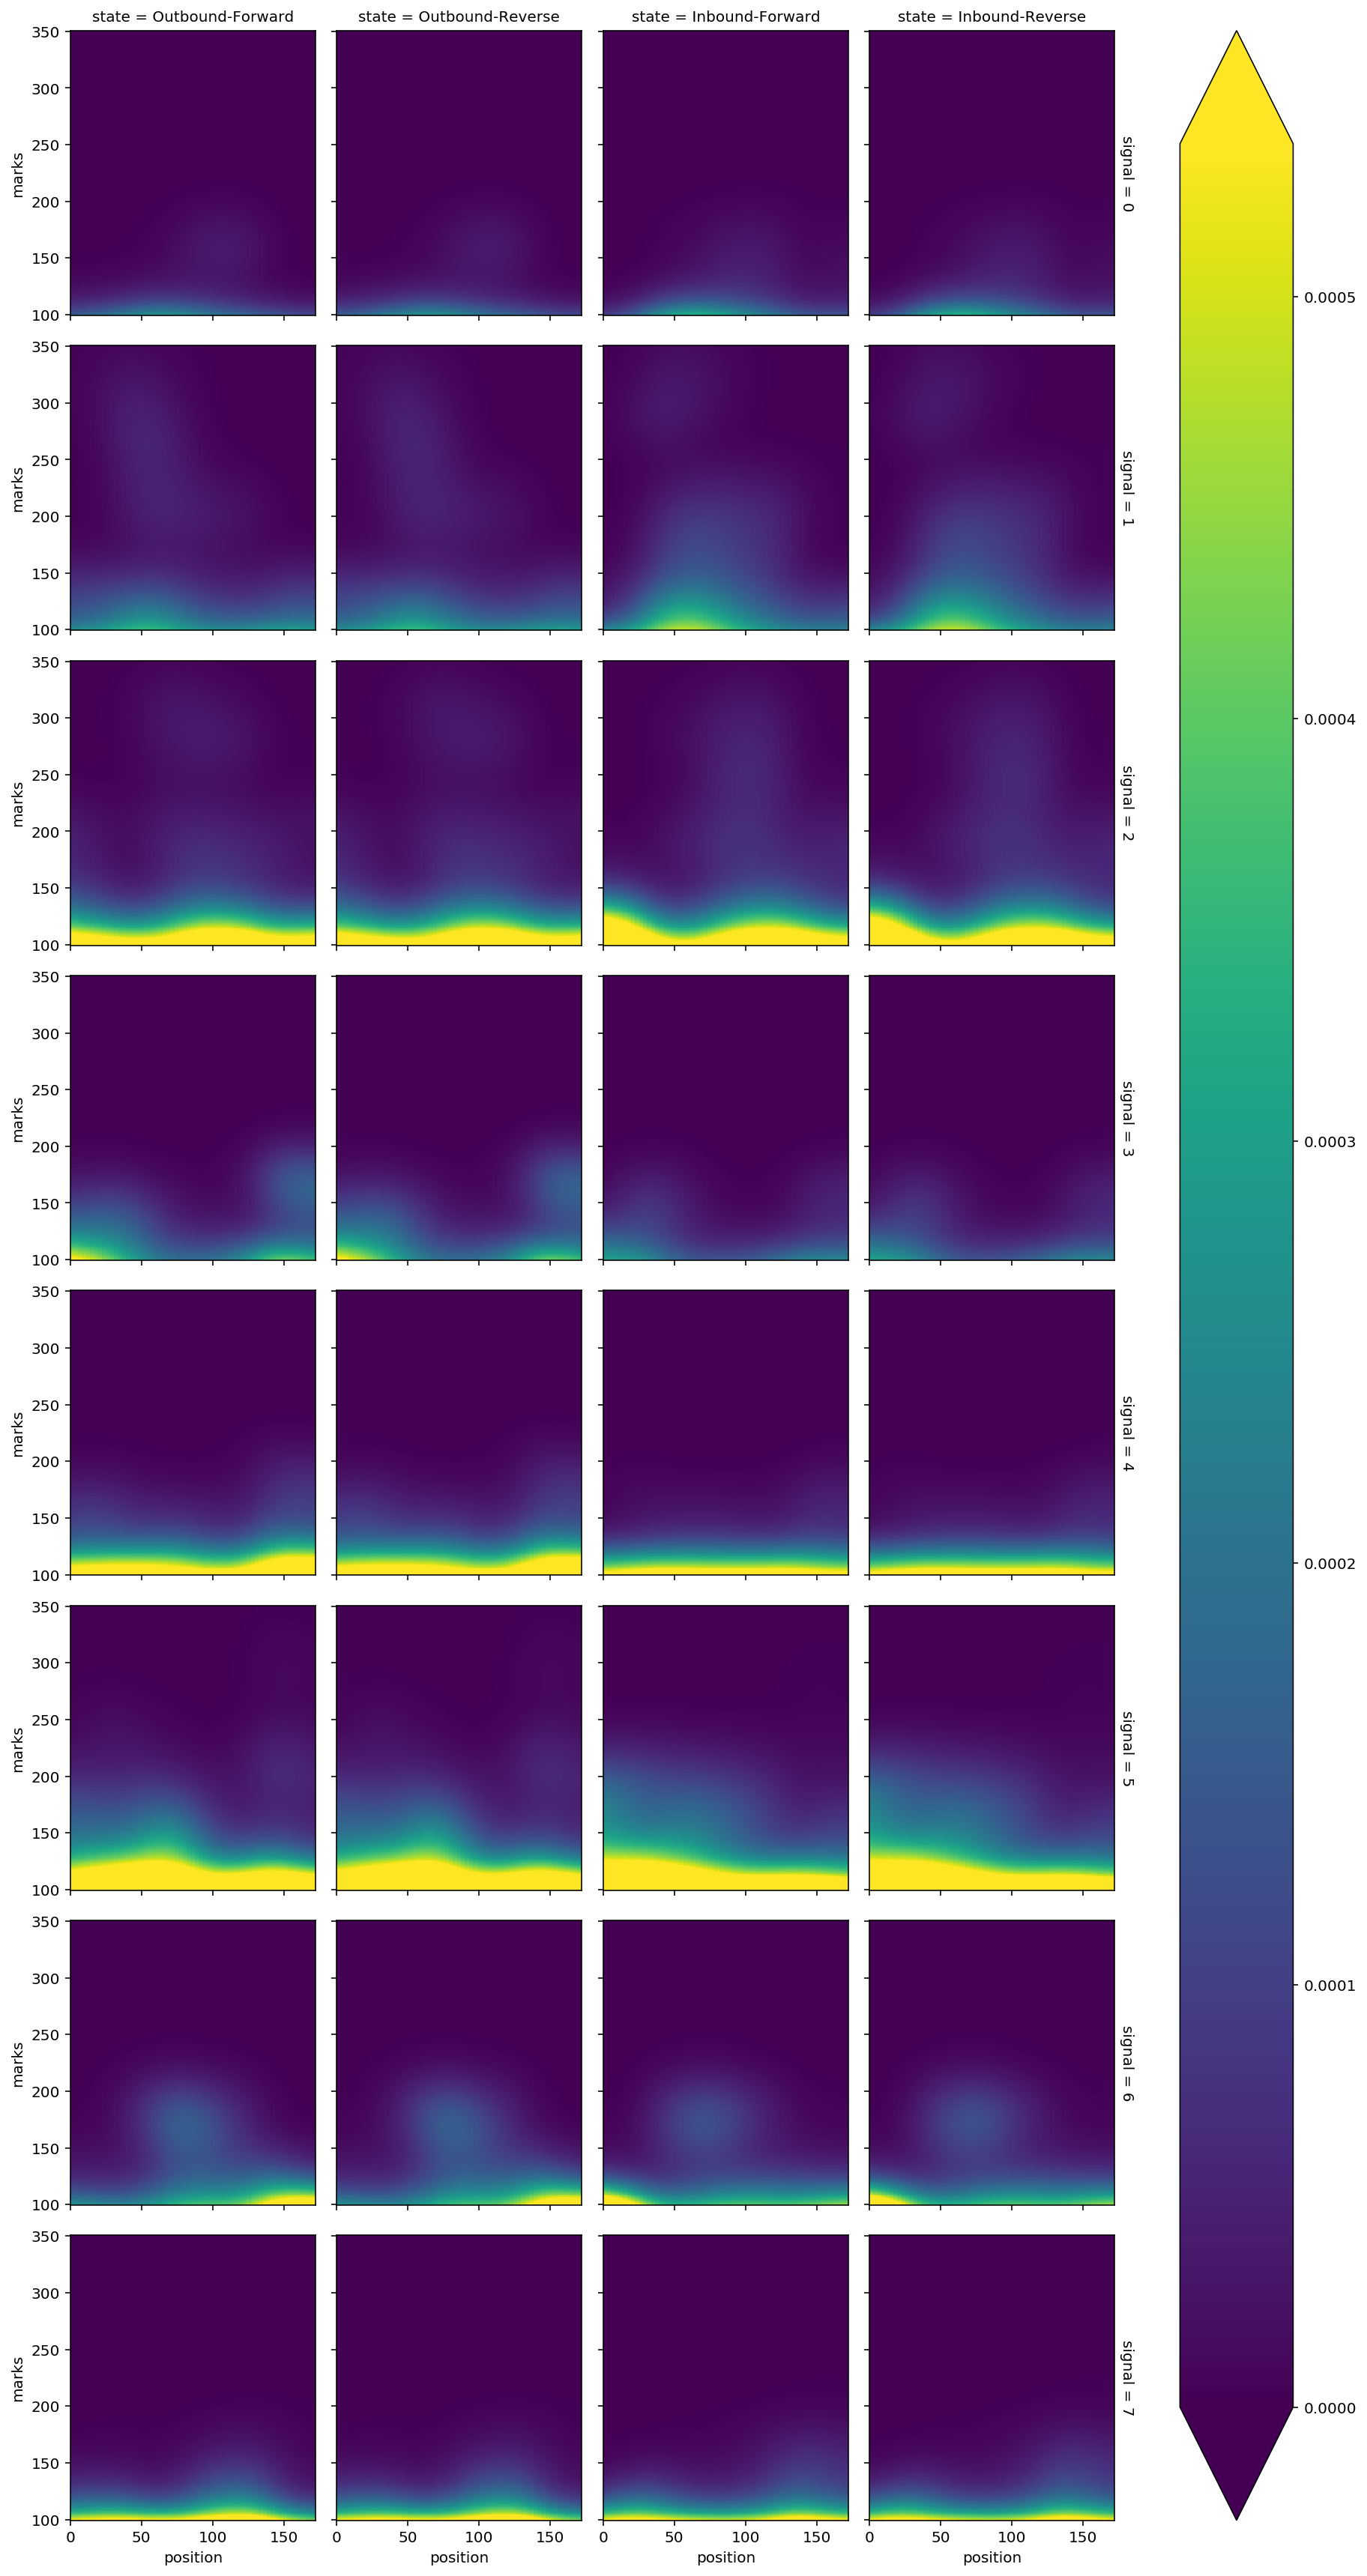

In [79]:
decoder.plot_observation_model()

In [192]:
from src.analysis import _get_ripple_marks

test_marks = _get_ripple_marks(marks, ripple_times, SAMPLING_FREQUENCY)
results = [decoder.predict(ripple_marks, time.total_seconds())
           for ripple_marks, time in test_marks]

In [193]:
from src.analysis import summarize_replay_results

(replay_info, decision_state_probability,
            posterior_density) = summarize_replay_results(
        results, ripple_times, position_info, epoch_key)

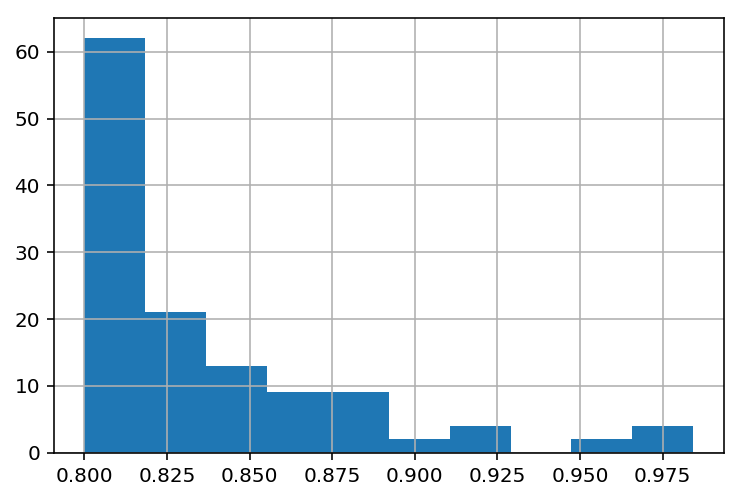

In [194]:
replay_info.predicted_state_probability.hist()

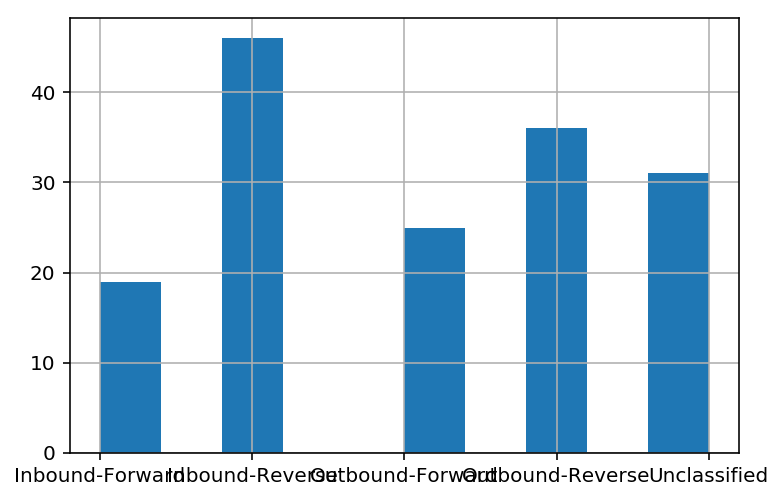

In [195]:
replay_info.predicted_state.hist()

In [196]:
def plot_posterior(ripple_number):
    g = posterior_density.isel(concat_dim=ripple_number).dropna('time').plot(
        x='time', y='position', col='state', col_wrap=2, robust=True, vmin=0);
    rat_position = replay_info.loc[ripple_number].linear_distance
    for ax in g.axes.ravel():
        ax.axhline(rat_position, color='white', linestyle='--', linewidth=3)
    plt.figure();
    state = (decision_state_probability.sel(concat_dim=ripple_number)
     .dropna('time').drop('concat_dim').to_dataframe().unstack(level=0))
    state.columns = state.columns.droplevel()
    state.plot();
    plt.figure();
    plt.plot(position_info.x_position.values, position_info.y_position.values)
    plt.scatter(replay_info.loc[ripple_number].x_position,
                replay_info.loc[ripple_number].y_position, color='red', zorder=100, s=100)
    plot_lfp(ripple_number);
interact(plot_posterior, ripple_number=(1, len(ripple_times)), continuous_update=False);

interactive(children=(IntSlider(value=79, description='ripple_number', max=157, min=1), Output()), _dom_classes=('widget-interact',))

In [165]:
neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = pd.merge(
    neuron_info.reset_index('neuron_number'), tetrode_info.loc[:, ['numcells', 'validripple']],
    right_index=True, left_index=True).set_index('neuron_number', append=True)
neuron_info = neuron_info[
    neuron_info.area.isin(['CA1']) &
    neuron_info.validripple & neuron_info.numspikes > 0]
spikes_data = [get_spike_indicator_dataframe(neuron_key, ANIMALS)
               for neuron_key in neuron_info.index]

# Make sure there are spikes in the training data times. Otherwise
# exclude that neuron
spikes_data = [spikes_datum for spikes_datum in spikes_data
               if spikes_datum[
                   position_info.speed > 4].sum() > 0]

train_spikes_data = [spikes_datum[position_info.speed > 4]
                     for spikes_datum in spikes_data]
decoder_sortedspikes = SortedSpikeDecoder(
    position=train_position_info.linear_distance.values,
    spikes=np.stack(train_spikes_data, axis=0),
    trajectory_direction=train_position_info.task.values,
    n_position_bins=n_position_bins,
    replay_speedup_factor=16,
).fit()

display(neuron_info)

INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...


area  csi hemisphere  meanrate  \
animal day epoch tetrode_number neuron_number                                  
bon    4   2     4              1              CA1  NaN      right  0.728814   
                                2              CA1  NaN      right  0.039195   
                 5              1              CA1  NaN      right  0.997881   
                                2              CA1  NaN      right  1.425847   
                                3              CA1  NaN      right  0.528602   
                                4              CA1  NaN      right  0.002119   
                                5              CA1  NaN      right  0.008475   
                 11             1              CA1  NaN      right  0.995763   
                                2              CA1  NaN      right  1.475636   
                                3              CA1  NaN      right  0.879237   
                                4              CA1  NaN      right  0.364407   
                                5              CA1  NaN      right  2.432203   
                 12             1              CA1  NaN       left  0.973517   
                                2              CA1  NaN       left  1.664195   
                                3              CA1  NaN       left  0.458686   
                 13             1              CA1  NaN       left  0.921610   
                                2              CA1  NaN       left  0.122881   
                                3              CA1  NaN       left  0.005297   
                                4              CA1  NaN       left  0.896186   
                 14             1              CA1  NaN       left  3.133475   
                                2              CA1  NaN       left  0.003178   
                                3              CA1  NaN       left  1.968220   
                                4              CA1  NaN       left  0.111229   
                                5              CA1  NaN       left  0.758475   
                                7              CA1  NaN       left  0.134534   
                 17             1              CA1  NaN       left  0.932203   
                 29             3              CA1  NaN      right  0.002119   
                                4              CA1  NaN      right  1.039195   

                                               nearCA2          neuron_id  \
animal day epoch tetrode_number neuron_number                               
bon    4   2     4              1                  0.0  bon_04_02_004_001   
                                2                  0.0  bon_04_02_004_002   
                 5              1                  0.0  bon_04_02_005_001   
                                2                  0.0  bon_04_02_005_002   
                                3                  0.0  bon_04_02_005_003   
                                4                  0.0  bon_04_02_005_004   
                                5                  0.0  bon_04_02_005_005   
                 11             1                  0.0  bon_04_02_011_001   
                                2                  0.0  bon_04_02_011_002   
                                3                  0.0  bon_04_02_011_003   
                                4                  0.0  bon_04_02_011_004   
                                5                  0.0  bon_04_02_011_005   
                 12             1                  0.0  bon_04_02_012_001   
                                2                  0.0  bon_04_02_012_002   
                                3                  0.0  bon_04_02_012_003   
                 13             1                  0.0  bon_04_02_013_001   
                                2                  0.0  bon_04_02_013_002   
                                3                  0.0  bon_04_02_013_003   
                                4                  0.0  bon_04_02_013_004   
                 14         

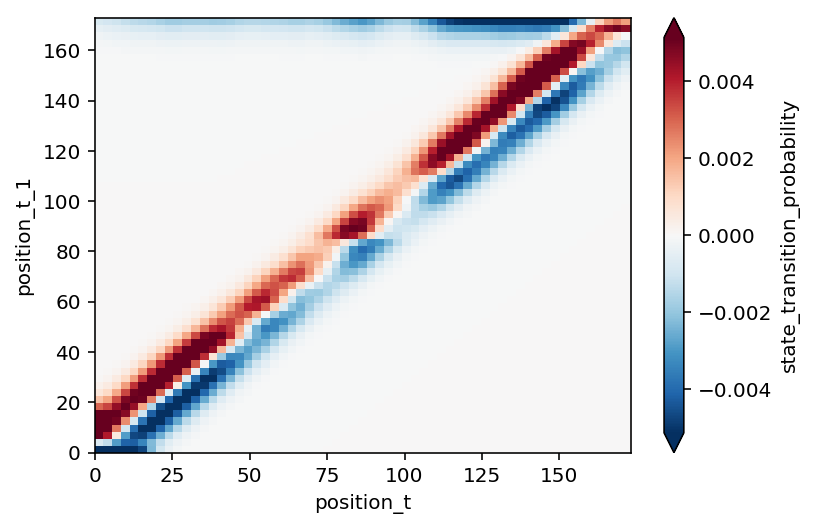

In [166]:
(decoder_sortedspikes.state_transition_matrix.sel(state='Inbound-Forward') -
 decoder_sortedspikes.state_transition_matrix.sel(state='Outbound-Forward')).plot(x='position_t', y='position_t_1', robust=True)

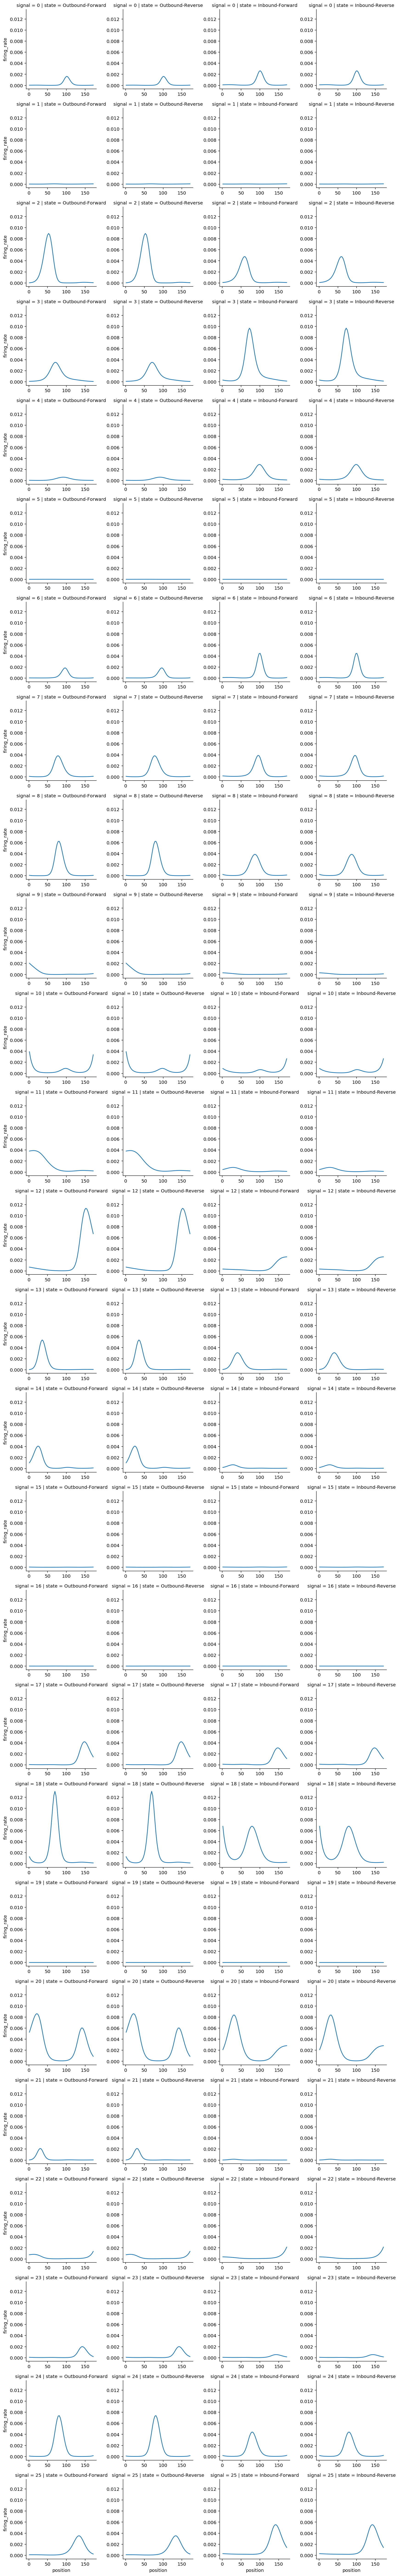

In [167]:
decoder_sortedspikes.plot_observation_model()

In [178]:
def _get_ripple_spikes(spikes_data, ripple_times, sampling_frequency):
    '''Given the ripple times, extract the spikes within the ripple
    '''
    spike_ripples = [reshape_to_segments(
        spikes_datum, ripple_times, axis=0, sampling_frequency=sampling_frequency)
        for spikes_datum in spikes_data]

    return [
        (np.stack([df.loc[ripple_number, :].values
                   for df in spike_ripples], axis=0).squeeze(),
         spike_ripples[0].loc[ripple_number, :].index.get_level_values('time'))
        for ripple_number in ripple_times.index]

test_spikes = _get_ripple_spikes(spikes_data, ripple_times, SAMPLING_FREQUENCY)
results_sortedspikes = [decoder_sortedspikes.predict(ripple_spikes, time.total_seconds())
           for ripple_spikes, time in test_spikes]

In [179]:
from src.analysis import summarize_replay_results

(replay_info_sortedspikes, decision_state_probability_sortedspikes,
            posterior_density_sortedspikes) = summarize_replay_results(
        results_sortedspikes, ripple_times, position_info, epoch_key)

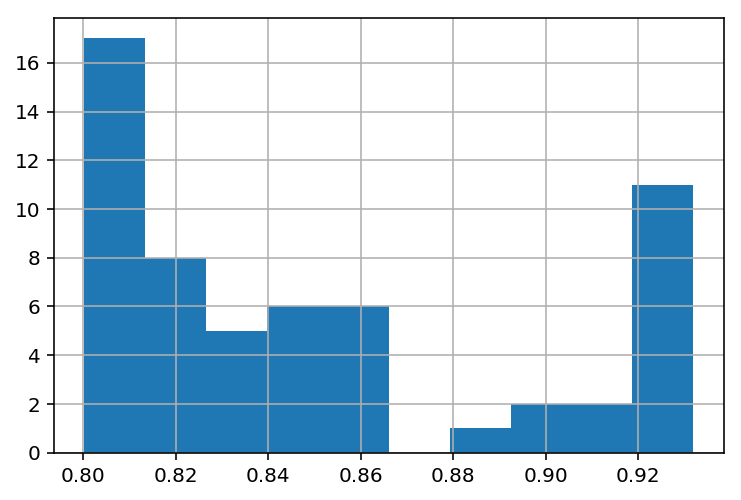

In [180]:
replay_info_sortedspikes.predicted_state_probability.hist()

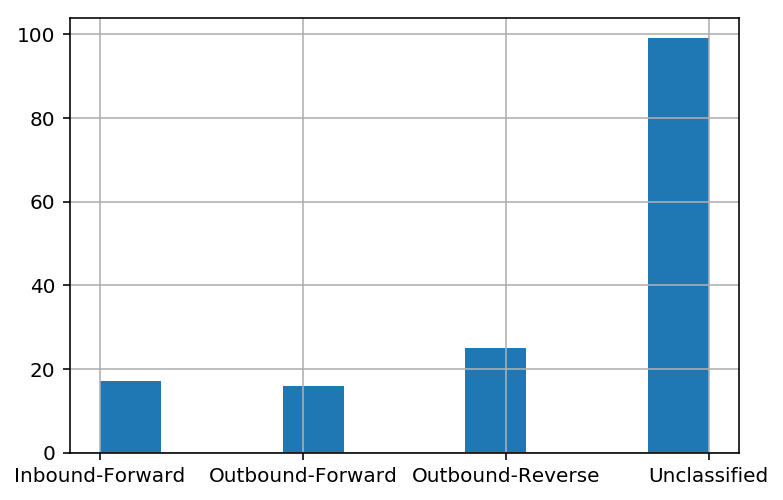

In [181]:
replay_info_sortedspikes.predicted_state.hist()

In [197]:
def plot_posterior_sortedspikes(ripple_number):
    g = posterior_density_sortedspikes.isel(concat_dim=ripple_number).dropna('time').plot(
        x='time', y='position', col='state', col_wrap=2, robust=True, vmin=0);
    rat_position = replay_info_sortedspikes.loc[ripple_number].linear_distance
    for ax in g.axes.ravel():
        ax.axhline(rat_position, color='white', linestyle='--', linewidth=3)
    plt.figure();
    state = (decision_state_probability_sortedspikes.sel(concat_dim=ripple_number)
     .dropna('time').drop('concat_dim').to_dataframe().unstack(level=0))
    state.columns = state.columns.droplevel()
    state.plot();
    plt.figure();
    plt.plot(position_info.x_position.values, position_info.y_position.values)
    plt.scatter(replay_info_sortedspikes.loc[ripple_number].x_position,
                replay_info_sortedspikes.loc[ripple_number].y_position, color='red', zorder=100, s=100)
    plot_lfp(ripple_number);
interact(plot_posterior_sortedspikes, ripple_number=(1, len(ripple_times)), continuous_update=False);

interactive(children=(IntSlider(value=79, description='ripple_number', max=157, min=1), Output()), _dom_classes=('widget-interact',))